In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/content/synthetic_water_quality_dataset_class.csv')
df.head()


,pH,Turbidity,Temperature,TDS,WQI_Class
0,6.998160,10.058762,39.101117,372.828701,Medium
1,9.302857,4.003170,5.601055,898.125006,Avg
2,8.427976,23.722659,38.167808,1281.423258,Avg
3,7.894634,0.498462,17.903710,801.536081,Medium
4,6.124075,4.238308,5.353164,747.319075,Medium


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df['WQI_Class'] = LabelEncoder().fit_transform(df['WQI_Class'])

df[['pH','Turbidity','Temperature','TDS']] = StandardScaler().fit_transform(
    df[['pH','Turbidity','Temperature','TDS']]
)

df.head()


,pH,Turbidity,Temperature,TDS,WQI_Class
0,-0.422914,-1.024909,1.621296,-1.189358,3
1,1.568495,-1.446794,-1.686990,-0.252003,0
2,0.812540,-0.072962,1.529127,0.431966,0
3,0.351698,-1.690963,-0.472046,-0.424360,3
4,-1.178182,-1.430412,-1.711471,-0.521106,3


In [4]:
from sklearn.model_selection import train_test_split

X = df[['pH','Turbidity','Temperature','TDS']].values
y = df['WQI_Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(5200, 4) (1300, 4)


In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)


In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [7]:
class WQI_ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(WQI_ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.gelu(self.fc2(x))
        x = self.fc3(x)   # Softmax applied internally by loss
        return x


In [8]:
input_dim = X_train.shape[1]
output_classes = len(np.unique(y))

model = WQI_ANN(input_dim, output_classes)
print(model)


WQI_ANN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (gelu): GELU(approximate='none')
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
epochs = 1000
train_loss, train_acc = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    train_loss.append(running_loss)
    train_acc.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss:.4f} | Acc: {acc:.4f}")


Epoch [1/1000] | Loss: 42.5197 | Acc: 0.8810
Epoch [2/1000] | Loss: 41.3314 | Acc: 0.8877
Epoch [3/1000] | Loss: 41.7037 | Acc: 0.8813
Epoch [4/1000] | Loss: 41.2179 | Acc: 0.8854
Epoch [5/1000] | Loss: 41.6569 | Acc: 0.8838
Epoch [6/1000] | Loss: 42.1292 | Acc: 0.8858
Epoch [7/1000] | Loss: 40.6233 | Acc: 0.8894
Epoch [8/1000] | Loss: 41.6067 | Acc: 0.8856
Epoch [9/1000] | Loss: 40.9974 | Acc: 0.8840
Epoch [10/1000] | Loss: 40.7472 | Acc: 0.8912
Epoch [11/1000] | Loss: 40.9351 | Acc: 0.8863
Epoch [12/1000] | Loss: 41.1771 | Acc: 0.8838
Epoch [13/1000] | Loss: 41.1729 | Acc: 0.8844
Epoch [14/1000] | Loss: 41.0154 | Acc: 0.8873
Epoch [15/1000] | Loss: 41.2064 | Acc: 0.8863
Epoch [16/1000] | Loss: 41.5587 | Acc: 0.8854
Epoch [17/1000] | Loss: 40.7840 | Acc: 0.8887
Epoch [18/1000] | Loss: 40.6267 | Acc: 0.8881
Epoch [19/1000] | Loss: 40.6761 | Acc: 0.8879
Epoch [20/1000] | Loss: 41.2944 | Acc: 0.8892
Epoch [21/1000] | Loss: 40.7671 | Acc: 0.8887
Epoch [22/1000] | Loss: 40.3577 | Acc: 0.88

In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


✅ Test Accuracy: 0.8431


In [13]:
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_classes = torch.argmax(y_pred, dim=1)

print(y_pred_classes[:10])


tensor([4, 2, 0, 3, 3, 4, 3, 4, 0, 0])


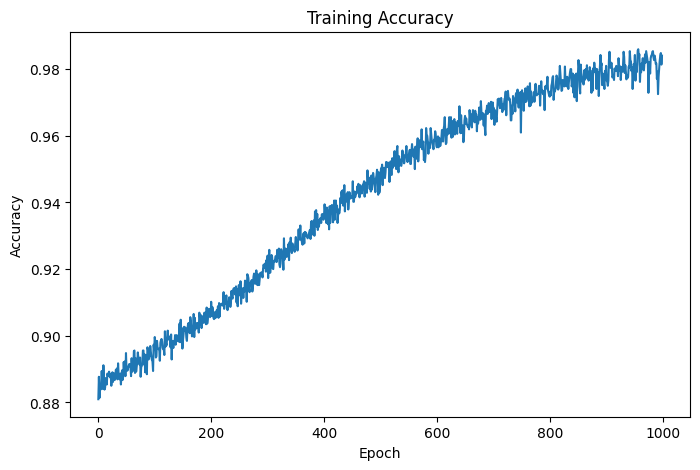

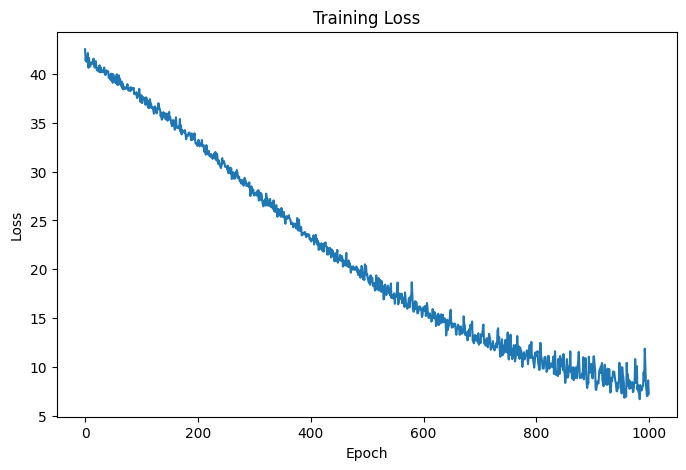

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [15]:
torch.save(model.state_dict(), "wqi_ann_model.pth")
print("✅ PyTorch model saved successfully")


✅ PyTorch model saved successfully


In [ ]:
import joblib
joblib.dump(scaler, "scaler.pkl")
